# Python data analysis script Version 1.0

This script takes `.json` files exported from the `[JSONWriter]` module of Corryvreckan, and is aimed towards analyzing and plotting the hit data.

## Importing data into python

### Reading in .json file

In [1]:
import json
import os

file = 'data/example.json'

with open(file) as json_file:
    data = json.load(json_file)

The JSON file is structured as follows:

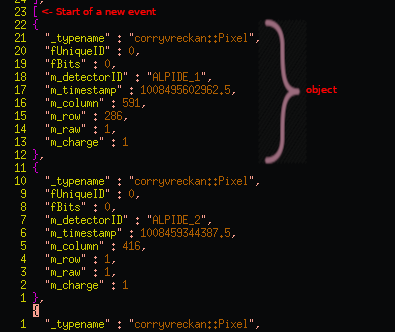

The information of a single pixel hit is stored inside of an object, and these objects are bundled into events.

### Writing all relevant data into one object

The goal of this section is to create a python object that contains all necessary data of all events. It should be able to be appended further down the line. The easiest way to do this is to use python lists and dictonaries.

In [2]:
hit_data = []    #initialize the list of all events
event_no = 0     #use a counter that will be incremented on each step

#Start the event loop
for event in data:
    
    #Skip over empty events
    if len(event) == 0: continue
        
    #Create a python dictionary for each event.
    hit_data.append({})
    
    #Create an entry in the dictionary for each plane
    for plane in range(7):
        hit_data[event_no][plane] = {}      #Stores all plane data
        hit_data[event_no][plane]["X"] = [] #Stores x-coordinates of hits
        hit_data[event_no][plane]["Y"] = [] #Stores y-coordinates of hits
    
    #Read out pixel by pixel
    for obj in event:
        
        #First, find out which plane the hit belongs to
        plane = int(obj["m_detectorID"].split("_")[1])
        #Second, read out x (column) and y (row) data
        hit_data[event_no][plane]["X"].append(int(obj["m_column"]))
        hit_data[event_no][plane]["Y"].append(int(obj["m_row"]))
        
    #Increment counter
    event_no+=1

For example, we can look at the 13th event like this:

In [3]:
# Look at the 13th event for example
hit_data[12]

{0: {'X': [], 'Y': []},
 1: {'X': [591], 'Y': [286]},
 2: {'X': [], 'Y': []},
 3: {'X': [], 'Y': []},
 4: {'X': [506], 'Y': [372]},
 5: {'X': [], 'Y': []},
 6: {'X': [], 'Y': []}}

### Adding some helpful information

For later analysis, it can come in handy, to seperate the events into different categories, based on the number of planes that have been hit. So we'll quickly add an entry for that.

In [4]:
for event in range(len(hit_data)):
    
    total_planes = 7 #Set the total number of planes
    
    for plane in range(total_planes):
        if not hit_data[event][plane]["X"]:        #for each empty event
            hit_data[event][plane]["X"].append(-1) #write a -1 into the hit array
            hit_data[event][plane]["Y"].append(-1) #---"---
            total_planes-=1                        #and substract one from the total number of planes
            
    #Add an entry into the dictionary
    hit_data[event]["number_of_planes"] = total_planes
    

In [5]:
hit_data[12]

{0: {'X': [-1], 'Y': [-1]},
 1: {'X': [591], 'Y': [286]},
 2: {'X': [-1], 'Y': [-1]},
 3: {'X': [-1], 'Y': [-1]},
 4: {'X': [506], 'Y': [372]},
 5: {'X': [-1], 'Y': [-1]},
 6: {'X': [-1], 'Y': [-1]},
 'number_of_planes': 2}

This way, we can add all sort of stuff into the dictionary as we go on, from tracking information, all the way to residuals and goodness-of-fit information.

## Calculating hit positions

For now, our data consisted of individual pixel hits. In the next step, we want to combine these hits into a cluster, to determine the
hit position more accurately

In [6]:
import numpy as np
from tqdm import tqdm

counter, bad_counter = 0,0

#Add a cool status bar
with tqdm(total=len(hit_data)) as pbar:

    for event in range(len(hit_data)):
    
        for plane in range(7):
        
            #Calculate the cluster position in X and Y (mean)
            Cluster_X = np.mean(hit_data[event][plane]["X"])
            Cluster_Y = np.mean(hit_data[event][plane]["Y"])
        
            #Calculate the standard deviation (the cluster spread)
            sdev = np.sqrt(np.std(hit_data[event][plane]["X"])**2+
                      np.std(hit_data[event][plane]["Y"])**2)
        
            #If the cluster consists of one pixel alone, the uncertainty is defined by the binary resolution
            if sdev == 0: sdev = 1/np.sqrt(12)
            
            #Round values a little bit
            sdev = np.round(sdev,2)
            Cluster_X = np.round(Cluster_X,2)
            Cluster_Y = np.round(Cluster_Y,2)
        
            #Add an entry to the dictionary
            hit_data[event][plane]["XC"] = Cluster_X
            hit_data[event][plane]["YC"] = Cluster_Y
            hit_data[event][plane]["sdev"] = sdev
                
        pbar.update(1)
                

100%|██████████| 87375/87375 [02:27<00:00, 592.67it/s]


In [7]:
#For example, look at the 13th event
hit_data[12]

{0: {'X': [-1], 'Y': [-1], 'XC': -1.0, 'YC': -1.0, 'sdev': 0.29},
 1: {'X': [591], 'Y': [286], 'XC': 591.0, 'YC': 286.0, 'sdev': 0.29},
 2: {'X': [-1], 'Y': [-1], 'XC': -1.0, 'YC': -1.0, 'sdev': 0.29},
 3: {'X': [-1], 'Y': [-1], 'XC': -1.0, 'YC': -1.0, 'sdev': 0.29},
 4: {'X': [506], 'Y': [372], 'XC': 506.0, 'YC': 372.0, 'sdev': 0.29},
 5: {'X': [-1], 'Y': [-1], 'XC': -1.0, 'YC': -1.0, 'sdev': 0.29},
 6: {'X': [-1], 'Y': [-1], 'XC': -1.0, 'YC': -1.0, 'sdev': 0.29},
 'number_of_planes': 2}

## Taking a first look at the data

We will be using the `mplot3d` toolkit from `matplotlib` to visualize the data. First we import it:

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import proj3d
%matplotlib notebook

Next we choose what data to plot, and how we want it to look like

In [9]:
#Define pixel pitches
ppx, ppy = 0.02924, 0.02688 #Pixel pitches in x and y [mm]

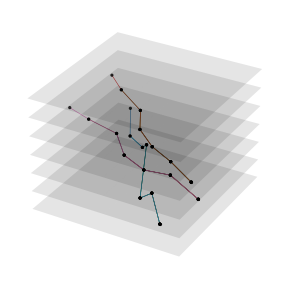

In [10]:
plot = 3                    #Plot the first 3 events
connect_hits = True         #Connects the hits
min_nop = 7                 #Plot only events that include 7 planes

#Create a figure object
xlim,ylim,zlim = 1023*ppx,511*ppy,6*20 #Dimensions of the detector (pixel pitch)
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')  #Create 3d Axes
ax._axis3don = False            #... but invisible
#ax.set_box_aspect((3,3,3))     #Define aspect ratio
ax.set_xlim3d(0,xlim)           #Axis limits in x
ax.set_ylim3d(0,ylim)           #Axis limits in y
ax.set_zlim3d(0,zlim)     
x = np.arange(0,1025*0.02924,512*0.02924) #Again convert pixel into mm
y = np.arange(0,1024*0.02688,512*0.02688)
X, Y = np.meshgrid(x,y)
Z = np.ndarray((len(y),len(x)))
Z.fill(0)

#Draw the planes
for plane in range(7):
    Z.fill(plane*20)
    ax.plot_surface(X,Y,Z,alpha=.1,color='black')

plot_counter = 0
#Plot the hits
for event in range(len(hit_data)):
    
    #Plot only events with the minimum amount of planes specified
    if (hit_data[event]['number_of_planes'] < min_nop): continue
        
    x_data, y_data, z_data = [], [], []
    
    for plane in range(7):
        
        #Skip over empty hits
        if (hit_data[event][plane]["XC"] == -1): continue
        
        #Put everything else into plottable arrays
        x_data.append(ppx*hit_data[event][plane]["XC"])
        y_data.append(ppy*hit_data[event][plane]["YC"])
        z_data.append(plane*20)

        ax.scatter3D(x_data,y_data,z_data,alpha=.7,color='black',marker='.')
        
        # OPTIONAL: Connect dots for Better visibility of Tracks
        if connect_hits:
            ax.plot(x_data,y_data,z_data, linewidth=.5)#, color='grey')
        
    plot_counter+=1
    if plot_counter == plot: break
    

## Tracking


In the next step, we'll investigate a way to approximate the data with 
tracks. Describing the data with tracks is a very useful concept that will later help us align the detector planes.

The first step is to approximate each event with a track. A track is a mathematical object, and is not limited to the pixel matrix. It has a much higher accuracy than the hits themselves.

Secondly, we want to assign a value to each track, describing the goodness-of-fit to the track. This will be done with a residual (chi squared) analysis.

In [11]:
# Define Initial Alignment (0 if unknown)
offset = np.ndarray((2,7))
offset[0][1], offset[1][1] = 0,0 #2.358, -0.127
offset[0][2], offset[1][2] = 0,0 #2.248, 1.507
offset[0][3], offset[1][3] = 0,0 #2.571, 3.645
offset[0][4], offset[1][4] = 0,0 #1.117, 4.811
offset[0][5], offset[1][5] = 0,0 #6.219, 1.520
offset[0][6], offset[1][6] = 0,0 #-4.222, -0.308

with tqdm(total=len(hit_data)) as pbar:
    
    #Loop over all events
    for event in range(len(hit_data)):
    
        #Number of planes belonging to the track
        nop = hit_data[event]["number_of_planes"]
    
        #Create some arrays to calculate in (convert px to mm)
        Fit_Data = np.ndarray((nop,3))
        std_hit = np.ndarray((nop))
        planes_used = [] #This is to exclude empty planes later

        #Create a counter for the Fit Array
        counter = 0
    
        #Loop over all planes
        for plane in range(7):
        
            #Skip empty planes
            if (hit_data[event][plane]["XC"] == -1): continue
            
            #Note which planes are non-empty
            planes_used.append(plane)
        
            #Align the planes with the formerly defined offset (STILL IN PX)
            hit_data[event][plane]["XC"]+=offset[0][plane]/ppx
            hit_data[event][plane]["YC"]+=offset[1][plane]/ppy
        
            #Convert pixel lengths into mm
            Fit_Data[counter][0] = ppx*hit_data[event][plane]["XC"]
            Fit_Data[counter][1] = ppy*hit_data[event][plane]["YC"]
            Fit_Data[counter][2] = plane*20
            std_hit[counter] = np.sqrt((ppx**2+ppy**2)/2)*hit_data[event][plane]["sdev"]
            counter+=1
    
        # Fitting Algorithm (Based on np.linalg.svd)
        datamean = Fit_Data.mean(axis=0)
        uu, dd, vv = np.linalg.svd(Fit_Data - datamean)
        linepts = vv[0] * np.mgrid[-2500*ppx:2500*ppy:2j][:,np.newaxis]
        linepts += datamean

        # Two Points Define the Fitted Track
        x1 = linepts[0]
        x2 = linepts[1]

        # Take the residual
        d = []
        for plane in planes_used:
            x0 = np.array([
                ppx*hit_data[event][plane]["XC"],
                ppy*hit_data[event][plane]["YC"],
                plane*20])
            
            # Solve for the point in plane of Track z = a+mb
            lbda = (x0[2] - x2[2])/(x2-x1)[2] # m = (z-a)/(b)
            xz = x2+lbda*(x2-x1) # find point in axis that lies in the same plane
            hit_data[event][plane]["resx"] = (x0-xz)[0]
            hit_data[event][plane]["resy"] = (x0-xz)[1]
            d.append(np.linalg.norm(xz-x0))

            # Proof that it works {{{
            #fig = plt.figure(figsize=(5,5))
            #ax = plt.axes(projection='3d')
            #x_track = [x1[0],x2[0]]
            #y_track = [x1[1],x2[1]]
            #z_track = [x1[2],x2[2]]
            #ax.plot(x_track,y_track,z_track)
            #ax.scatter(x0[0],x0[1],x0[2])
            #ax.scatter(xz[0],xz[1],xz[2])

            #x = np.arange(0,1025,512)
            #y = np.arange(0,1024,512)
            #X, Y = np.meshgrid(x,y)
            #Z = np.ndarray((len(y),len(x)))
            #Z.fill(0)
            ## Draw the planes
            #for plane in range(7):
            #    Z.fill(plane*1024*2/3)
            #    ax.plot_surface(X,Y,Z,alpha=.1,color='black')
            #plt.show() }}}

        #Add an entry into the dictionary containing the track coordinates
        hit_data[event]["Track_Point_1"], hit_data[event]["Track_Point_2"] = [],[]
        for i in range(3):
            hit_data[event]["Track_Point_1"].append(x1[i])
            hit_data[event]["Track_Point_2"].append(x2[i])

        # From there, calculate chi2 to determine the goodness of the fit
        chi2 = 0
        for entry in range(len(d)):
            chi2 += d[entry]**2/std_hit[entry]**2
    
        hit_data[event]["chi2"] = chi2
        
        pbar.update(1)

100%|██████████| 87375/87375 [00:22<00:00, 3869.27it/s]


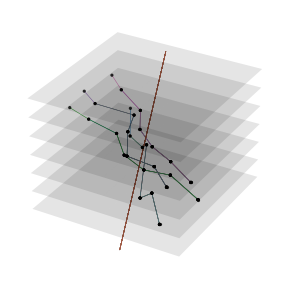

In [12]:
plot = 3                    #Plot the first X events
connect_hits = True         #Connects the hits
plot_tracks = True         #Plot tracks associated to events
min_nop = 7                 #Plot only events that include 7 planes

#Create a figure object
xlim,ylim,zlim = 1023*ppx,511*ppy,6*20 #Dimensions of the detector (pixel pitch)
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')  #Create 3d Axes
ax._axis3don = False            #... but invisible
#ax.set_box_aspect((3,3,3))     #Define aspect ratio
ax.set_xlim3d(0,xlim)           #Axis limits in x
ax.set_ylim3d(0,ylim)           #Axis limits in y
ax.set_zlim3d(0,zlim)     
x = np.arange(0,1025*0.02924,512*0.02924) #Again convert pixel into mm
y = np.arange(0,1024*0.02688,512*0.02688)
X, Y = np.meshgrid(x,y)
Z = np.ndarray((len(y),len(x)))
Z.fill(0)

#Draw the planes
for plane in range(7):
    Z.fill(plane*20)
    ax.plot_surface(X,Y,Z,alpha=.1,color='black')

plot_counter = 0

#Plot the hits
for event in range(len(hit_data)):
    
    #Plot only events with the minimum amount of planes specified
    if (hit_data[event]['number_of_planes'] < min_nop): continue
        
    x_data, y_data, z_data = [], [], []
    
    for plane in range(7):
        
        #Skip over empty hits
        if (hit_data[event][plane]["XC"] == -1): continue
        
        #Put everything else into plottable arrays
        x_data.append(ppx*hit_data[event][plane]["XC"])
        y_data.append(ppy*hit_data[event][plane]["YC"])
        z_data.append(plane*20)

        ax.scatter3D(x_data,y_data,z_data,alpha=.7,color='black',marker='.')
        
        # OPTIONAL: Connect dots for Better visibility of Tracks
        if connect_hits:
            ax.plot(x_data,y_data,z_data, linewidth=.5)#, color='grey')
    
        # OPTIONAL: Plot tracks associated to events
        if plot_tracks:
            x_track = [hit_data[i]['Track_Point_1'][0],hit_data[i]['Track_Point_2'][0]]
            y_track = [hit_data[i]['Track_Point_1'][1],hit_data[i]['Track_Point_2'][1]]
            z_track = [hit_data[i]['Track_Point_1'][2],hit_data[i]['Track_Point_2'][2]]
            ax.plot(x_track,y_track,z_track,linewidth=.5)
            
    plot_counter+=1
    if plot_counter > plot: break
